In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib, json

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [112]:
full_df = pd.read_pickle("econ_sample.pkl") # Load your tweets
full_df.head()
full_df.columns

,text,tweetid,userid,screen_name,date,lang,state,country,tweet_type,friends_count,verified,hashtag,rt_screen,rt_userid,rt_text,sent_vader,qtd_screen,qtd_userid,qtd_text
93298,RT @nw_nicholas: U.K. has the lowest state pen...,1411652805950066696,303049436,andrewamg,2021-07-04 11:47:10+00:00,en,NaN,NaN,retweeted_tweet_without_comment,4232,False,[],nw_nicholas,2.235391e+08,"U.K. has the lowest state pension in EU, the w...",-0.9274,NaN,NaN,NaN
68026,RT @slightwright: Can we get one more stimulus...,1393438269010976768,4923321404,stephcastlee_,2021-05-15 05:29:06+00:00,en,NaN,NaN,retweeted_tweet_without_comment,187,False,[],slightwright,1.348284e+18,Can we get one more stimulus before the govern...,-0.1761,NaN,NaN,NaN
24287,This is bold for @GovRonDeSantis who still owe...,1396966972378828801,474456942,marianalesandra,2021-05-24 23:10:55+00:00,en,FL,United States,quoted_tweet,865,False,[],NaN,NaN,NaN,-0.0258,cnnbrk,428333.0,Florida will stop paying jobless residents the...
45810,RT @essenviews: Mitch McConnell slams Democrat...,1357001925963767813,431268135,christiansarkar,2021-02-03 16:24:05+00:00,en,NaN,NaN,retweeted_tweet_without_comment,18354,False,[],essenviews,2.998864e+09,Mitch McConnell slams Democrats for using the ...,-0.2732,NaN,NaN,NaN
34576,@RepAdamSchiff That 600 a week is extra money ...,1289491207777849344,22175710,nanna59,2020-08-01 09:20:36+00:00,en,NaN,NaN,reply,2040,False,[],NaN,NaN,NaN,0.0572,NaN,NaN,NaN


Index(['text', 'tweetid', 'userid', 'screen_name', 'date', 'lang', 'state',
       'country', 'tweet_type', 'friends_count', 'verified', 'hashtag',
       'rt_screen', 'rt_userid', 'rt_text', 'sent_vader', 'qtd_screen',
       'qtd_userid', 'qtd_text'],
      dtype='object')

In [113]:
full_df.rt_text = full_df.rt_text.fillna("")
full_df.text = full_df.text.fillna("")

In [114]:
df = full_df[["friends_count", "verified", "sent_vader", "country", "state", "lang", "date"]]
df

,friends_count,verified,sent_vader,country,state,lang,date
93298,4232,False,-0.9274,NaN,NaN,en,2021-07-04 11:47:10+00:00
68026,187,False,-0.1761,NaN,NaN,en,2021-05-15 05:29:06+00:00
24287,865,False,-0.0258,United States,FL,en,2021-05-24 23:10:55+00:00
45810,18354,False,-0.2732,NaN,NaN,en,2021-02-03 16:24:05+00:00
34576,2040,False,0.0572,NaN,NaN,en,2020-08-01 09:20:36+00:00
...,...,...,...,...,...,...,...
65062,0,False,-0.8856,NaN,NaN,en,2021-02-25 05:53:04+00:00
23497,1007,False,-0.4215,Brazil,NaN,en,2020-06-21 10:13:37+00:00
16462,102,False,0.2263,NaN,NaN,en,2020-12-27 16:09:20+00:00
40965,265,False,-0.2263,NaN,NaN,en,2020-12-24 10:33:39+00:00


In [125]:
# dictionary to add a column of political affilation based on the state results from 2020

political_affil_state = {
    'MT': 'Red', 'ID': 'Red', 'UT': 'Red', 'WY': 'Red',
    'SD': 'Red', 'ND': 'Red', 'NE': 'Red', 'IA': 'Red',
    'MO': 'Red', 'KS': 'Red', 'OK': 'Red', 'TX': 'Red',
    'AR': 'Red', 'LA': 'Red', 'MS': 'Red', 'AL': 'Red',
    'TN': 'Red', 'KY': 'Red', 'IN': 'Red', 'OH': 'Red',
    'WV': 'Red', 'NC': 'Red', 'SC': 'Red', 'FL': 'Red', 'AK': 'Red', #Red states
    
    'WA': 'Blue', 'OR': 'Blue', 'NV': 'Blue', 'CA': 'Blue',
    'NM': 'Blue', 'CO': 'Blue', 'MN': 'Blue', 'IL': 'Blue',
    'NY': 'Blue', 'VA': 'Blue', 'NJ': 'Blue', 'MD': 'Blue',
    'DE': 'Blue', 'CT': 'Blue', 'MA': 'Blue', 'RI': 'Blue',
    'NH': 'Blue', 'VT': 'Blue', 'ME': 'Blue', 'HI': 'Blue', #Blue states
    
    'AZ': 'Flip', 'WI': 'Flip', 'MI': 'Flip', 'GA': 'Flip', 
    'PA': 'Flip'} #Flip states

def get_political_affil(state):
    #default to 'Unknown' if the state abbreviation is not found in the mapping
    return political_affil_state.get(state, 'Unknown')
df['political_affil'] = df['state'].apply(get_political_affil)
df['political_affil']

/var/folders/p9/zhd87k2j2b1224y0ny7xcjx40000gn/T/ipykernel_20745/707130217.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['political_affil'] = df['state'].apply(get_political_affil)


93298    Unknown
68026    Unknown
24287        Red
45810    Unknown
34576    Unknown
          ...   
65062    Unknown
23497    Unknown
16462    Unknown
40965    Unknown
62547    Unknown
Name: political_affil, Length: 1000000, dtype: object

In [10]:
df.country.value_counts().head(30)

country
United States     349041
India              23430
United Kingdom     16797
Canada             11240
Australia           7053
South Africa        4692
Nigeria             3657
Ireland             1724
Philippines         1589
Kenya               1514
Germany             1406
Malaysia            1341
Pakistan            1278
France              1182
Japan                961
Spain                831
New Zealand          716
Mexico               668
Indonesia            653
Netherlands          620
Switzerland          560
Uganda               552
Belgium              541
Brazil               522
Italy                510
Ghana                469
Hong Kong            447
Singapore            435
Colombia             385
Thailand             353
Name: count, dtype: int64

In [ ]:
# geographic variations in setiment score:

In [140]:
# country-based:
country_grp = df.groupby("country")["sent_vader"].mean().sort_values()

# selecting top 10 and bottom 10 countries based on sentiment score
country_top_10 = country_grp.tail(7).iloc[:-1] # most positive
country_bottom_10 = country_grp.head(6) # most negative
country_sent = pd.concat([country_bottom_10, country_top_10]).reset_index()
country_sent.columns = ['country', 'mean_sent_vader']

print(country_sent)

                                  country  mean_sent_vader
0                                 Bélgica        -0.951700
1                                   Suíça        -0.947900
2                               Gibraltar        -0.725480
3                          Cayman Islands        -0.722057
4                                Finnland        -0.700300
5                                 Burundi        -0.689300
6                                 Réunion         0.421500
7                                 Grenada         0.422800
8             Hashemite Kingdom of Jordan         0.453500
9                              East Timor         0.495100
10  Former Yugoslav Republic of Macedonia         0.599400
11                             Montenegro         0.664775


<Figure size 900x600 with 0 Axes>

Text(0.0, 0, 'Bélgica')

Text(1.0, 0, 'Suíça')

Text(2.0, 0, 'Gibraltar')

Text(3.0, 0, 'Cayman Islands')

Text(4.0, 0, 'Finnland')

Text(5.0, 0, 'Burundi')

Text(6.0, 0, 'Réunion')

Text(7.0, 0, 'Grenada')

Text(8.0, 0, 'Hashemite Kingdom of Jordan')

Text(9.0, 0, 'East Timor')

Text(10.0, 0, 'Former Yugoslav Republic of Macedonia')

Text(11.0, 0, 'Montenegro')

Text(0.5, 0, 'Country')

Text(0, 0.5, 'Mean Sentiment Score')

Text(0.5, 1.0, 'Countries with the Lowest and Highest Mean Sentiments')

([], [])

(-1.0, 1.0)

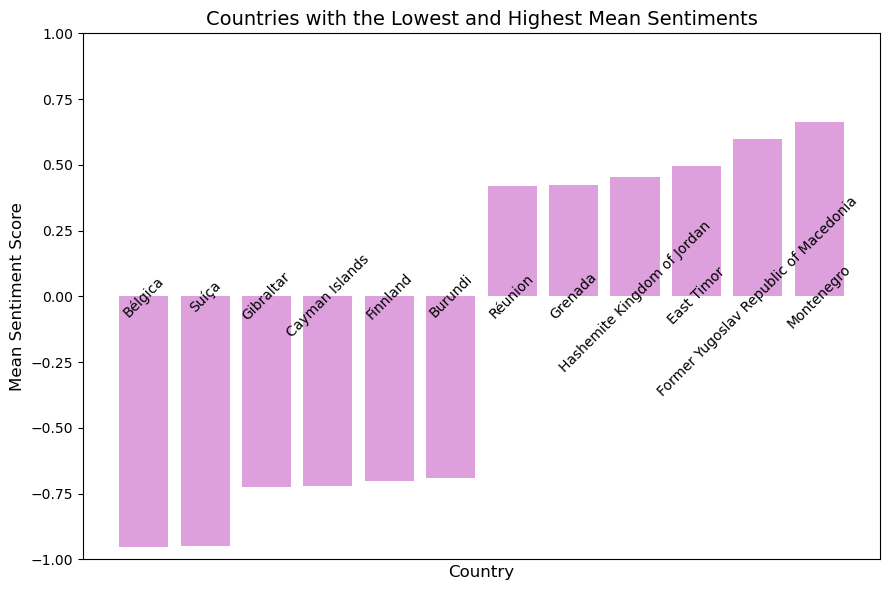

In [143]:
plt.figure(figsize=(9, 6))
bars = plt.bar(country_sent['country'], country_sent['mean_sent_vader'], color='plum')

# moving the country names to the y = 0 horizontal axis
for bar, country in zip(bars, country_sent['country']):
    plt.text(bar.get_x() + bar.get_width() / 2, 0, country, ha='center', va='center', fontsize=10, rotation=45)

plt.xlabel('Country', fontsize=12)
plt.ylabel('Mean Sentiment Score', fontsize=12)
plt.title('Countries with the Lowest and Highest Mean Sentiments', fontsize=14)
plt.xticks([], [])
plt.ylim(-1, 1)
plt.tight_layout()

plt.show()


#plt.figure(figsize=(10, 6))
#plt.bar(country_sent['country'], country_sent['mean_sent_vader'], color='skyblue')

#plt.xlabel('Country', fontsize=12)
#plt.ylabel('Mean Sentiment Score', fontsize=12)
#plt.title('Lowest and Highest Sentiment Scores by Country', fontsize=14)
#plt.xticks(rotation=45, ha='right')
#plt.tight_layout()

#plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.0, -0.1837787456445993, '-0.20')

Text(1.0, -0.09477762114537445, '-0.11')

Text(2.0, -0.15265403692477267, '-0.17')

Text(3.0, -0.08561620370370371, '-0.11')

Text(4.0, -0.13759599761644653, '-0.16')

Text(5.0, -0.12989249205184641, '-0.15')

Text(0.5, 1.0, 'States with the Lowest and Highest Mean Sentiments, by Affiliation')

Text(0, 0.5, 'Mean Sentiment Score')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'ND'),
  Text(1, 0, 'WV'),
  Text(2, 0, 'NV'),
  Text(3, 0, 'VT'),
  Text(4, 0, 'PA'),
  Text(5, 0, 'MI')])

Text(0.5, 0, 'State')

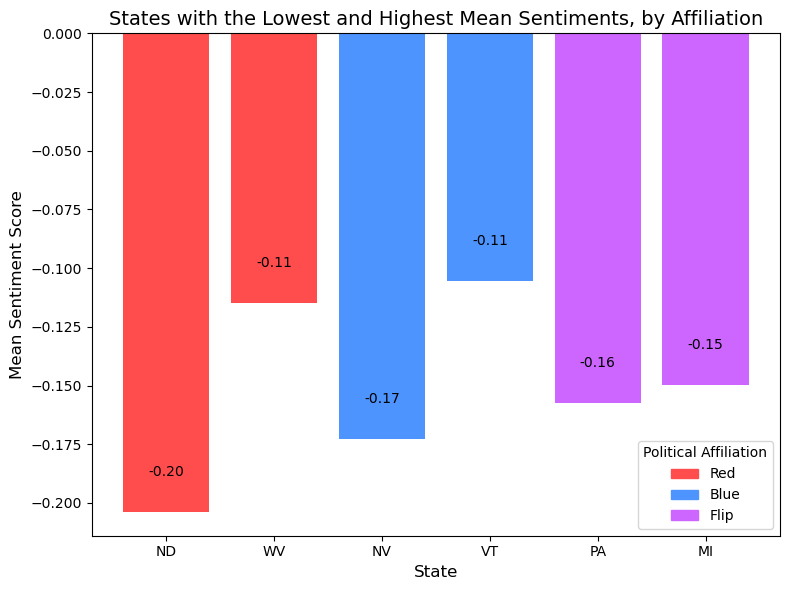

In [144]:
# state-based:

# filter out the "Unknown" political affiliation (which is probably International or the state name is just not available)
politically_affiliated_df = df[df["political_affil"].isin(["Red", "Blue", "Flip"])]

# grouping both on the affiliation and states for each:
state_grp = politically_affiliated_df.groupby(["political_affil", "state"])["sent_vader"].mean().reset_index()

# now, for each of these three affiliations, find the state with the highest and lowest mean sent_vader score
selected_states = []
for affiliation in ["Red", "Blue", "Flip"]:
    affil_states = state_grp[state_grp["political_affil"] == affiliation]
    highest_state = affil_states.loc[affil_states["sent_vader"].idxmax()]
    lowest_state = affil_states.loc[affil_states["sent_vader"].idxmin()]
    selected_states.extend([lowest_state, highest_state])

selected_states_df = pd.DataFrame(selected_states)

color_mapping = {"Red": "#ff4d4d", "Blue": "#4d94ff", "Flip": "#cc66ff"}
colors = [color_mapping[affil] for affil in selected_states_df["political_affil"]]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(
    selected_states_df["state"],  # Use only state names for x-axis labels
    selected_states_df["sent_vader"],
    color=colors,
)

# political affiliations legend
handles = [
    plt.Rectangle((0, 0), 1, 1, color=color_mapping["Red"], label="Red"),
    plt.Rectangle((0, 0), 1, 1, color=color_mapping["Blue"], label="Blue"),
    plt.Rectangle((0, 0), 1, 1, color=color_mapping["Flip"], label="Flip"),
]
plt.legend(handles=handles, title="Political Affiliation", loc="lower right", fontsize=10)

# adding the values of sentiment score as labels inside the bars themselves
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - (0.02 if bar.get_height() > 0 else -0.02),
        f"{bar.get_height():.2f}",
        ha="center",
        va="bottom" if bar.get_height() > 0 else "top",
        fontsize=10,
        color="black",
    )

plt.title("States with the Lowest and Highest Mean Sentiments, by Affiliation", fontsize=14)
plt.ylabel("Mean Sentiment Score", fontsize=12)
plt.xticks(fontsize=10)
plt.xlabel("State", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# sentiment based on social markers

In [35]:
df['friends_count'].describe()

count    1000000.000000
mean        1994.372758
std         6905.293299
min            0.000000
25%          186.000000
50%          569.000000
75%         1806.000000
max       618575.000000
Name: friends_count, dtype: float64

In [42]:
# Tweets from verified users tend to score a bit higher on sentiment
df.groupby("verified")["sent_vader"].mean().sort_values()

verified
False   -0.196858
True    -0.074330
Name: sent_vader, dtype: float64

In [56]:
# regression: predicting sentiment score based on social markers:
# one feature
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df[['friends_count']] # continuous independent var
y = df['sent_vader'] # target var

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# instantiating and fitting the linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# our predictions
y_pred = model.predict(X_test)

# evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}; R-squared Score: {r2}")
print(f"Coefficient (slope): {model.coef_[0]}; Intercept: {model.intercept_}")

LinearRegression()

Mean Squared Error: 0.32220899260042535; R-squared Score: 0.0003792817098554613
Coefficient (slope): 1.6010478768610937e-06; Intercept: -0.1971511131305344


In [57]:
# adding another variable as a feature to try to improve our model a bit

X = df[['friends_count', 'verified']]  # including both 'friends_count' (continuous var) and 'verified' (boolean var) as features
y = df['sent_vader']

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# instantiating and fitting the linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# our predictions
y_pred = model.predict(X_test)

# evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}; R-squared Score: {r2}")
print(f"Coefficients: {model.coef_}; Intercept: {model.intercept_}")

LinearRegression()

Mean Squared Error: 0.32185754645270304; R-squared Score: 0.0014696077364233506
Coefficients: [1.48908532e-06 1.19593527e-01]; Intercept: -0.19989541448423503


In [52]:
# log-transforming the friends_count variable to take into account the diminishing returns after a certain treshold value and
# to help with skewed data. we do this to normalize the distribution and make the resulting relationship with the dependent var more linear
df['log_friends_count'] = np.log1p(df['friends_count'])  # log1p handles the dangerous log(0) safely by computing log(1 + x)

X = df[['log_friends_count', 'verified']]  # log-transformed 'friends_count' and 'verified' features
y = df['sent_vader']

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# instantiating and fitting the linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# our predictions
y_pred = model.predict(X_test)

# evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}; R-squared Score: {r2:.4f}")
print(f"Coefficients: {model.coef_}; Intercept: {model.intercept_}")

/var/folders/p9/zhd87k2j2b1224y0ny7xcjx40000gn/T/ipykernel_20745/3210606295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_friends_count'] = np.log1p(df['friends_count'])  # log1p handles the dangerous log(0) safely by computing log(1 + x)


LinearRegression()

Mean Squared Error: 0.3212; R-squared Score: 0.0035
Coefficients: [0.01548716 0.11002392]; Intercept: -0.29360113702029367


/var/folders/p9/zhd87k2j2b1224y0ny7xcjx40000gn/T/ipykernel_20745/1147413843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified'] = df['verified'].astype(int)


<Figure size 1000x600 with 0 Axes>

/opt/anaconda3/envs/qss20/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/qss20/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Text(0.5, 0, 'Friends Count')

Text(0, 0.5, 'Sentiment Score')

Text(0.5, 1.0, 'Sentiment Score based on Friends Count, by Verification')

/opt/anaconda3/envs/qss20/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


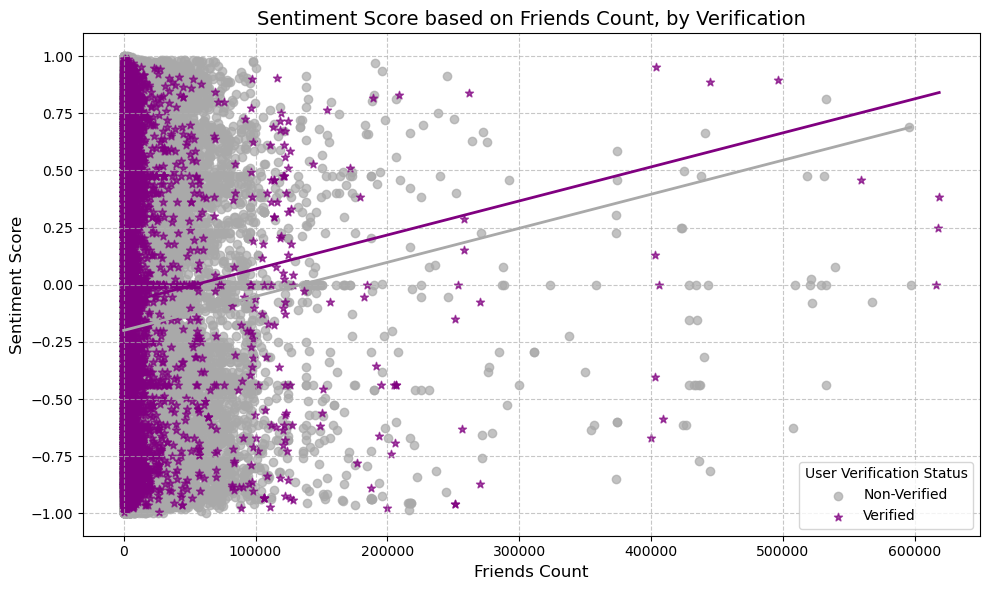

In [62]:
df['verified'] = df['verified'].astype(int)
verified = df[df['verified'] == 1]
non_verified = df[df['verified'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(non_verified['friends_count'], non_verified['sent_vader'], 
            alpha=0.7, color='darkgray', label='Non-Verified', marker='o')
plt.scatter(verified['friends_count'], verified['sent_vader'], 
            alpha=0.7, color='purple', label='Verified', marker='*')

# regression line for non-verified users
x_vals_non_verified = np.linspace(non_verified['friends_count'].min(), non_verified['friends_count'].max(), 100)
y_vals_non_verified = model.predict(np.column_stack([x_vals_non_verified, np.zeros_like(x_vals_non_verified)]))
plt.plot(x_vals_non_verified, y_vals_non_verified, color='darkgray', linewidth=2)

# regression line for verified users
x_vals_verified = np.linspace(verified['friends_count'].min(), verified['friends_count'].max(), 100)
y_vals_verified = model.predict(np.column_stack([x_vals_verified, np.ones_like(x_vals_verified)]))
plt.plot(x_vals_verified, y_vals_verified, color='purple', linewidth=2)

plt.xlabel('Friends Count', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.title('Sentiment Score based on Friends Count, by Verification', fontsize=14)
plt.legend(title='User Verification Status', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [68]:
df_date = df.sort_values(by='date')

,friends_count,verified,sent_vader,country,state,lang,date,log_friends_count
1353,18012,0,-0.8020,NaN,NaN,en,2020-01-22 20:52:49+00:00,9.798849
4744,2303,0,-0.8360,NaN,NaN,en,2020-01-23 13:55:36+00:00,7.742402
43695,4934,0,-0.8442,United States,MI,en,2020-01-24 15:56:41+00:00,8.504108
28201,54,0,-0.6908,NaN,NaN,en,2020-01-24 16:40:50+00:00,4.007333
18485,186,0,-0.7300,United Kingdom,NaN,en,2020-01-24 21:31:12+00:00,5.231109
...,...,...,...,...,...,...,...,...
27099,158,0,-0.6808,NaN,NaN,en,2022-06-29 23:31:42+00:00,5.068904
27387,349,0,-0.6705,United States,NaN,en,2022-06-29 23:32:05+00:00,5.857933
36364,29,0,-0.4926,NaN,NaN,en,2022-06-29 23:43:19+00:00,3.401197
41461,103,0,-0.6801,NaN,NaN,en,2022-06-29 23:49:51+00:00,4.644391


<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Sentiment Score')

Text(0.5, 1.0, 'Sampled Sentiment Score Over Time')

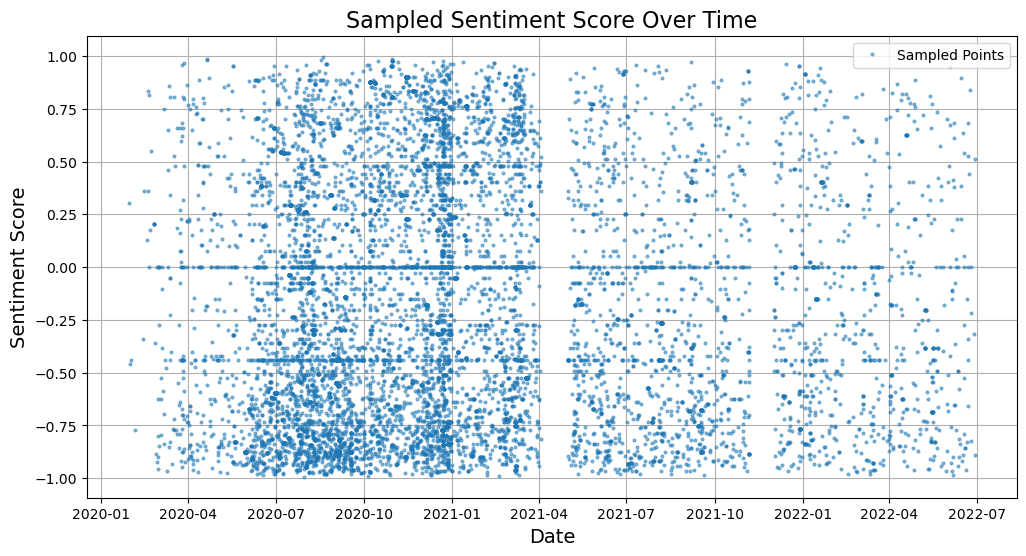

In [70]:
sampled_df = df_date.sample(n=10000, random_state=42)  # Randomly sample 10,000 rows

plt.figure(figsize=(12, 6))
plt.plot(sampled_df['date'], sampled_df['sent_vader'], 'o', markersize=2, alpha=0.5, label='Sampled Points')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)
plt.title('Sampled Sentiment Score Over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Sentiment Score')

Text(0.5, 1.0, 'Sentiment Score Over Time')

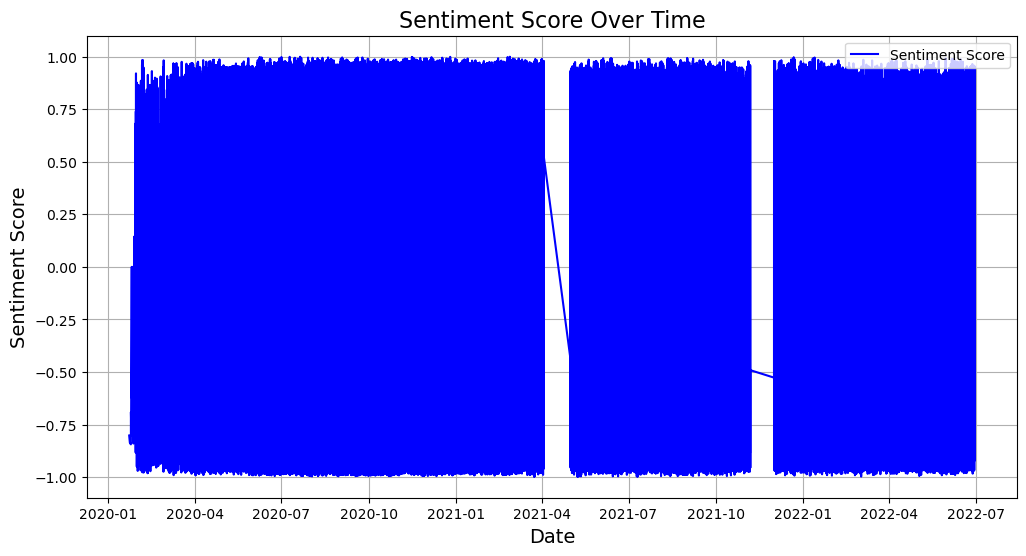

In [69]:
plt.figure(figsize=(12, 6))  # Set figure size
plt.plot(df_date['date'], df_date['sent_vader'], color='blue', label='Sentiment Score')  # Line plot
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)
plt.title('Sentiment Score Over Time', fontsize=16)
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.show()

In [73]:
df_text = full_df[["sent_vader", "country", "state", "lang", "date", "rt_text"]]
df_text

,sent_vader,country,state,lang,date,rt_text
93298,-0.9274,NaN,NaN,en,2021-07-04 11:47:10+00:00,"U.K. has the lowest state pension in EU, the w..."
68026,-0.1761,NaN,NaN,en,2021-05-15 05:29:06+00:00,Can we get one more stimulus before the govern...
24287,-0.0258,United States,FL,en,2021-05-24 23:10:55+00:00,
45810,-0.2732,NaN,NaN,en,2021-02-03 16:24:05+00:00,Mitch McConnell slams Democrats for using the ...
34576,0.0572,NaN,NaN,en,2020-08-01 09:20:36+00:00,
...,...,...,...,...,...,...
65062,-0.8856,NaN,NaN,en,2021-02-25 05:53:04+00:00,Massive Unemployment Crisis in India! Women ...
23497,-0.4215,Brazil,NaN,en,2020-06-21 10:13:37+00:00,US billionaires wealth added since the beginni...
16462,0.2263,NaN,NaN,en,2020-12-27 16:09:20+00:00,Millions of Americans have now lost their unem...
40965,-0.2263,NaN,NaN,en,2020-12-24 10:33:39+00:00,"US President tweets,: Trump puts GOP on its he..."


In [78]:
vaccine_df = df_text[df_text['rt_text'].str.contains("lockdown", case=False, na=False)]
vaccine_df

,sent_vader,country,state,lang,date,rt_text
27717,0.0000,NaN,NaN,en,2020-09-16 09:16:41+00:00,Did we relax too much? Do we need to lockdown ...
117371,0.2263,NaN,NaN,en,2020-11-14 22:55:59+00:00,Girls don’t want a boyfriend girls want a six ...
49094,-0.7351,NaN,NaN,en,2021-02-24 02:34:33+00:00,▪️Petrol @ 100 ▪️Diesel ▪️LPG @ 769 ▪️Unemploy...
5284,0.7109,United States,NY,en,2020-11-11 21:02:30+00:00,"I would love to be on lockdown, on unemploymen..."
35072,-0.3612,NaN,NaN,en,2020-07-05 04:17:13+00:00,I survived the Covid-19 lockdown unemployment ...
...,...,...,...,...,...,...
120718,0.8655,NaN,NaN,en,2020-08-11 04:57:39+00:00,Save Salon India! Appeal to @narendramodi @PMO...
66363,-0.8856,NaN,NaN,en,2021-02-25 05:53:41+00:00,Massive Unemployment Crisis in India! Women ...
57452,-0.7906,NaN,NaN,en,2020-08-09 07:28:58+00:00,Women informal workers who are the only earnin...
86745,-0.7407,United States,CA,en,2021-02-03 00:46:29+00:00,STIMULUS (stim·​u·​lus) noun 1: something tha...


In [79]:
vaccine_df = vaccine_df.sort_values(by='date')

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Sentiment Score')

Text(0.5, 1.0, 'Sentiment Score Over Time for Tweets Containing "Vaccine"')

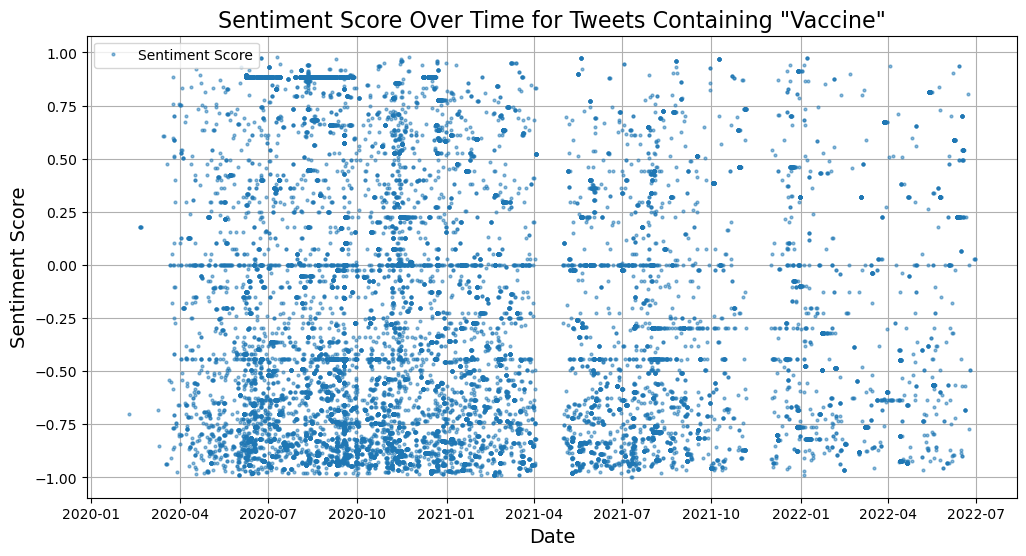

In [80]:
plt.figure(figsize=(12, 6))
plt.plot(vaccine_df['date'], vaccine_df['sent_vader'], 'o', markersize=2, alpha=0.5, label='Sentiment Score')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)
plt.title('Sentiment Score Over Time for Tweets Containing "Vaccine"', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# dictionary to add a column of political affilation based on the state results from 2020

political_affil_state = {
    'MT': 'Red', 'ID': 'Red', 'UT': 'Red', 'WY': 'Red',
    'SD': 'Red', 'ND': 'Red', 'NE': 'Red', 'IA': 'Red',
    'MO': 'Red', 'KS': 'Red', 'OK': 'Red', 'TX': 'Red',
    'AR': 'Red', 'LA': 'Red', 'MS': 'Red', 'AL': 'Red',
    'TN': 'Red', 'KY': 'Red', 'IN': 'Red', 'OH': 'Red',
    'WV': 'Red', 'NC': 'Red', 'SC': 'Red', 'FL': 'Red', 'AK': 'Red', #Red states
    
    'WA': 'Blue', 'OR': 'Blue', 'NV': 'Blue', 'CA': 'Blue',
    'NM': 'Blue', 'CO': 'Blue', 'MN': 'Blue', 'IL': 'Blue',
    'NY': 'Blue', 'VA': 'Blue', 'NJ': 'Blue', 'MD': 'Blue',
    'DE': 'Blue', 'CT': 'Blue', 'MA': 'Blue', 'RI': 'Blue',
    'NH': 'Blue', 'VT': 'Blue', 'ME': 'Blue', 'HI': 'Blue', #Blue states
    
    'AZ': 'Flip', 'WI': 'Flip', 'MI': 'Flip', 'GA': 'Flip', 
    'PA': 'Flip'} #Flip states

def get_political_affil(state):
    #default to 'Unknown' if the state abbreviation is not found in the mapping
    return political_affil_state.get(state, 'Unknown')
df['political_affil'] = df['state'].apply(get_political_affil)
df['political_affil']

/var/folders/p9/zhd87k2j2b1224y0ny7xcjx40000gn/T/ipykernel_20745/707130217.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['political_affil'] = df['state'].apply(get_political_affil)


93298    Unknown
68026    Unknown
24287        Red
45810    Unknown
34576    Unknown
          ...   
65062    Unknown
23497    Unknown
16462    Unknown
40965    Unknown
62547    Unknown
Name: political_affil, Length: 1000000, dtype: object

In [83]:
df

,friends_count,verified,sent_vader,country,state,lang,date,log_friends_count,political_affil
93298,4232,0,-0.9274,NaN,NaN,en,2021-07-04 11:47:10+00:00,8.350666,Unknown
68026,187,0,-0.1761,NaN,NaN,en,2021-05-15 05:29:06+00:00,5.236442,Unknown
24287,865,0,-0.0258,United States,FL,en,2021-05-24 23:10:55+00:00,6.763885,Red
45810,18354,0,-0.2732,NaN,NaN,en,2021-02-03 16:24:05+00:00,9.817657,Unknown
34576,2040,0,0.0572,NaN,NaN,en,2020-08-01 09:20:36+00:00,7.621195,Unknown
...,...,...,...,...,...,...,...,...,...
65062,0,0,-0.8856,NaN,NaN,en,2021-02-25 05:53:04+00:00,0.000000,Unknown
23497,1007,0,-0.4215,Brazil,NaN,en,2020-06-21 10:13:37+00:00,6.915723,Unknown
16462,102,0,0.2263,NaN,NaN,en,2020-12-27 16:09:20+00:00,4.634729,Unknown
40965,265,0,-0.2263,NaN,NaN,en,2020-12-24 10:33:39+00:00,5.583496,Unknown


In [ ]:
# multinomial logistic regression (just multiclasss classification)

In [ ]:
# regressing the categorical political_affil dummies to get the friends_count var

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

# preprocessing to encode our discrete data into numeric vals: 
le = LabelEncoder()
df['political_affil_encoded'] = le.fit_transform(df['political_affil'])

X = df[['friends_count']]  # continuous feature
y = df['political_affil_encoded']  # encoded target (dependent) var

# transforming the "friends_count" to get rid of the diminishing rate of returns after extremely high vals
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# instantiating and fitting the multinomial logistic regression
# we used the lbfgs solver limited-memory Broyden-Fletcher-Goldfarb-Shanno solver for these classes
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# our predictions
y_pred = model.predict(X_test)

# evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

/var/folders/p9/zhd87k2j2b1224y0ny7xcjx40000gn/T/ipykernel_20745/2600476135.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['political_affil_encoded'] = le.fit_transform(df['political_affil'])
/opt/anaconda3/envs/qss20/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

Accuracy: 0.70329
Confusion Matrix:
[[    39      0      7  30118]
 [    14      0      0   7647]
 [    26      0      0  21404]
 [   119      0      7 140619]]

Classification Report:
              precision    recall  f1-score   support

        Blue       0.20      0.00      0.00     30164
        Flip       0.00      0.00      0.00      7661
         Red       0.00      0.00      0.00     21430
     Unknown       0.70      1.00      0.83    140745

    accuracy                           0.70    200000
   macro avg       0.23      0.25      0.21    200000
weighted avg       0.53      0.70      0.58    200000



/opt/anaconda3/envs/qss20/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/qss20/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/qss20/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [90]:
# observe: high accuracy would suggest that the model correctly predicts the political_affil 70.33% of the time; BUT
# but high accuracy doesn't necessarily mean the model is good bcuz it could be biased toward the majority class
# (i.e. the Unknown category) due to class imbalance

In [ ]:
# so we filter out the Unknown class which dominates the dataset to get better classification for minority classes: Blue, Flip, and Red:

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

minority_df = df[df['political_affil'] != 'Unknown']

X = minority_df[['friends_count']]
y = minority_df['political_affil']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

LogisticRegression(class_weight='balanced')

Accuracy: 0.47814055513372145
Confusion Matrix:
 [[22940   261  7114]
 [ 5662    64  1880]
 [15727   284  5333]]
Classification Report:
               precision    recall  f1-score   support

        Blue       0.52      0.76      0.61     30315
        Flip       0.11      0.01      0.02      7606
         Red       0.37      0.25      0.30     21344

    accuracy                           0.48     59265
   macro avg       0.33      0.34      0.31     59265
weighted avg       0.41      0.48      0.42     59265



<Figure size 800x600 with 0 Axes>

/var/folders/p9/zhd87k2j2b1224y0ny7xcjx40000gn/T/ipykernel_20745/2855147989.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='political_affil', y='friends_count', palette=color_palette, data=df_filtered)


<Axes: xlabel='political_affil', ylabel='friends_count'>

Text(0.5, 1.0, 'Filtered Distribution of Friends Count by Political Affiliation')

Text(0.5, 0.98, '')

Text(0.5, 0, 'Political Affiliation')

Text(0, 0.5, 'Friends Count')

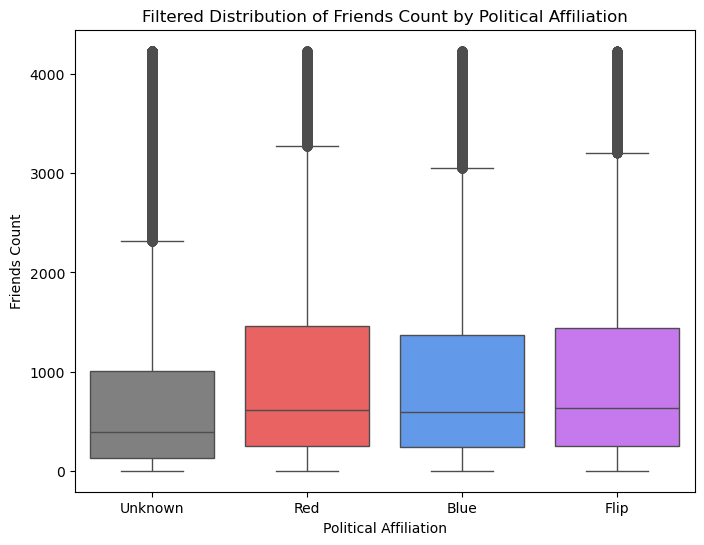

In [145]:
# 25th percentile, 75th percentile, and IQR
Q1 = df['friends_count'].quantile(0.25)
Q3 = df['friends_count'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# getting rid of the outliers
df_filtered = df[(df['friends_count'] >= lower_bound) & (df['friends_count'] <= upper_bound)]

color_palette = {"Unknown": "gray" , "Red": "#ff4d4d", "Blue": "#4d94ff", "Flip": "#cc66ff"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='political_affil', y='friends_count', palette=color_palette, data=df_filtered)
plt.title("Filtered Distribution of Friends Count by Political Affiliation")
plt.suptitle('')
plt.xlabel('Political Affiliation')
plt.ylabel('Friends Count')
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='verified', ylabel='count'>

Text(0.5, 1.0, 'Distribution of Political Affiliation by Twitter Verification Status')

Text(0.5, 0, 'Twitter Verification Status')

Text(0, 0.5, 'Count')

([<matplotlib.axis.XTick at 0x30793cb80>,
 [Text(0, 0, 'Non-Verified'), Text(1, 0, 'Verified')])

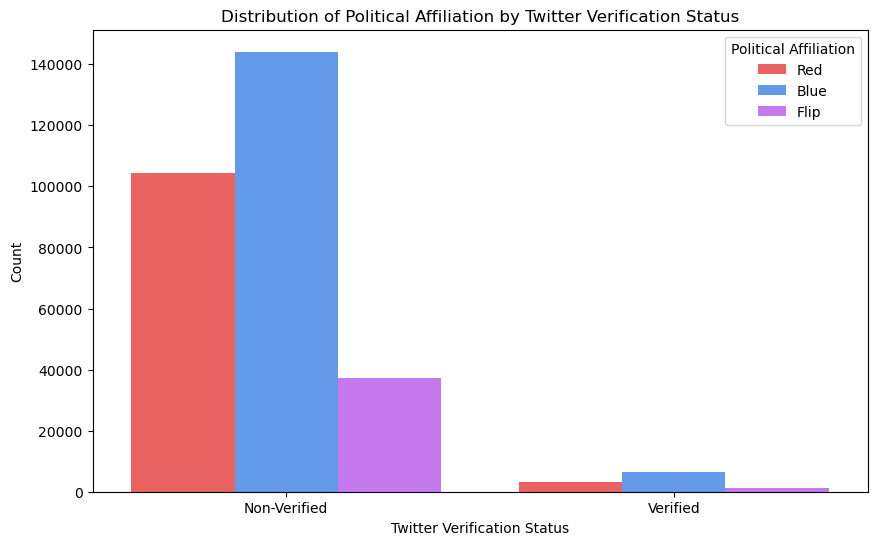

In [110]:
# filtering out the 'Unknown' class
minority_df = df[df['political_affil'].isin(['Red', 'Blue', 'Flip'])]
minority_color_palette = {"Red": "#ff4d4d", "Blue": "#4d94ff", "Flip": "#cc66ff"}

plt.figure(figsize=(10, 6))
sns.countplot(x='verified', hue='political_affil', data=minority_df, palette=minority_color_palette)
plt.title("Distribution of Political Affiliation by Twitter Verification Status")
plt.xlabel("Twitter Verification Status")
plt.ylabel("Count")
plt.legend(title="Political Affiliation")
plt.xticks(ticks=[0, 1], labels=["Non-Verified", "Verified"])

plt.show()